<a href="https://colab.research.google.com/github/pymedphys/pymedphys/blob/master/examples/protyping/tensorflow/002-DeepMind_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install pynrrd tf-nightly

# !git clone https://github.com/deepmind/tcia-ct-scan-dataset.git

# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt install git-lfs

# !cd tcia-ct-scan-dataset && git lfs pull

In [2]:
import os
import pathlib
import functools
import random

import tqdm

import matplotlib.pyplot as plt
import numpy as np

import nrrd

# %tensorflow_version 2.x
import tensorflow as tf
tf.__version__  # Expect '>= 2.2.0-dev20200312'

'2.2.0-dev20200312'

In [0]:
data_root = pathlib.Path('tcia-ct-scan-dataset/nrrds')
test_data_roots = list(data_root.glob('test/*/*'))
validation_data_roots = list(data_root.glob('validation/*/*'))

In [0]:
GRID_SIZE = 512
Z_CONTEXT_DISTANCE = 3
BATCH_SIZE = 1

TENSOR_TYPE = tf.float16

In [0]:
# @functools.lru_cache()  # This uses too much RAM
def load_data(path):
    return nrrd.read(path)

In [0]:
def get_random_dataset(paths, structure_name, z_context_distance, tensor_type):
    while True:
        data_path = random.choice(paths)
        structure_data, structure_header = load_data(data_path.joinpath(f'segmentations/{structure_name}.nrrd'))

        slices = np.shape(structure_data)[-1]
        slice_choice = random.randint(z_context_distance, slices - 1 - z_context_distance)

        to_contain_structure = bool(random.randint(0, 1))
        no_structure_found = np.all(structure_data[:, :, slice_choice] == 0)

        if to_contain_structure != no_structure_found:
            break

    ct_data, ct_header = load_data(data_path.joinpath('CT_IMAGE.nrrd'))

    slice_to_use = slice(
        slice_choice - z_context_distance,
        slice_choice + z_context_distance + 1
    )
    ct_slices = ct_data[:, :, slice_to_use]
    structure_slice = structure_data[:, :, slice_choice]

    model_input = tf.convert_to_tensor(ct_slices[:,:,:,None], dtype=tensor_type)
    model_output = tf.convert_to_tensor(structure_slice[:,:,None,None], dtype=tensor_type)

    return model_input, model_output


# get_random_dataset(test_data_roots, 'Spinal-Cord', Z_CONTEXT_DISTANCE, TENSOR_TYPE)

In [10]:
def create_dataset_pipeline(paths, batch_size, grid_size, structure_name, z_context_distance, tensor_type):
    def dataset_generetor():
        yield get_random_dataset(paths, structure_name, z_context_distance, tensor_type)

    num_input_slices = z_context_distance * 2 + 1

    dataset = tf.data.Dataset.from_generator(
        dataset_generetor,
        (tensor_type, tensor_type),
        (
            tf.TensorShape([grid_size, grid_size, num_input_slices, 1]), 
            tf.TensorShape([grid_size, grid_size, 1, 1])
        )
    )

    dataset = dataset.repeat().batch(batch_size)

    return dataset


create_dataset = functools.partial(
    create_dataset_pipeline, 
    batch_size=BATCH_SIZE,
    grid_size=GRID_SIZE,
    structure_name='Spinal-Cord',
    z_context_distance=Z_CONTEXT_DISTANCE,
    tensor_type=TENSOR_TYPE
)


test_dataset = create_dataset(test_data_roots)
validation_dataset = create_dataset(validation_data_roots)

for model_input, model_output in test_dataset.take(1):
    print(f"{model_input.shape}, {model_output.shape}")

(1, 512, 512, 7, 1), (1, 512, 512, 1, 1)


In [0]:
tf.keras.backend.clear_session()

initializer = tf.random_normal_initializer(0., 0.02)


def down_block(x, depth, m, n, channels, pool):
    convolution_sequence = tf.keras.Sequential(name=f'down-convolution-d{depth}')
    convolution_sequence.add(
        tf.keras.layers.ReLU()
    )
    for _ in range(m):
        convolution_sequence.add(
            tf.keras.layers.Conv3D(
                channels, (3, 3, 1), strides=1, padding='same',
                kernel_initializer=initializer, use_bias=False)
        )
    
    for i in range(n):
        convolution_sequence.add(
            tf.keras.layers.Conv3D(
                channels, (3, 3, 1), strides=1, padding='same',
                kernel_initializer=initializer, use_bias=False)
        )
        convolution_sequence.add(
            tf.keras.layers.Conv3D(
                channels, (1, 1, 3), strides=1, padding='valid',
                kernel_initializer=initializer, use_bias=False)
        )

        if i != n - 1:
            convolution_sequence.add(
                tf.keras.layers.ReLU()
            )
    
    short_circuit_sequence = tf.keras.Sequential(name=f'down-short-circuit-d{depth}')
    short_circuit_sequence.add(tf.keras.layers.Cropping3D((0,0,n)))
    short_circuit_sequence.add(
        tf.keras.layers.Conv3D(
            channels, (1, 1, 1), strides=1, padding='same',
            kernel_initializer=tf.ones_initializer(), 
            use_bias=False)
    )
    
    x = tf.keras.layers.Add()(
        [convolution_sequence(x), short_circuit_sequence(x)]
    )
    
    unet_short_circuit = x
    
    if pool != 0:
        x = tf.keras.layers.AveragePooling3D((pool, pool, 1), strides=None, padding='valid')(x)
        
    return x, unet_short_circuit


def fully_connected_block(x, input_size, internal_channels, output_channels):
    x = tf.keras.layers.Conv3D(
            internal_channels, 
            (input_size, input_size, 1),
            strides=1,
            padding='valid',
            kernel_initializer=initializer,
            use_bias=True
    )(x)
    
    repeats = 2
    for _ in range(repeats):
        short_circuit = x
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dense(internal_channels)(x)
        x = tf.keras.layers.Add()([x, short_circuit])
    
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(input_size * input_size * output_channels)(x)
    
    x = tf.keras.layers.Reshape((input_size, input_size, 1, output_channels))(x)
    
    return x
    

def up_block(x, unet_short_circuit, depth, cropping, m, channels, up_scale):
    unet_short_circuit = tf.keras.layers.Cropping3D((0,0,cropping))(
        unet_short_circuit
    )

    if up_scale != 0:
        x = tf.keras.layers.UpSampling3D(size=(up_scale, up_scale, 1))(x)
        
    x = tf.keras.layers.Concatenate(axis=-2)([x, unet_short_circuit])
    
    convolution_sequence = tf.keras.Sequential(name=f'up-convolution-d{depth}')
    convolution_sequence.add(
        tf.keras.layers.ReLU()
    )
    for _ in range(m):
        convolution_sequence.add(
            tf.keras.layers.Conv3D(
                channels, (3, 3, 1), strides=1, padding='same',
                kernel_initializer=initializer, use_bias=False)
        )
        convolution_sequence.add(
            tf.keras.layers.ReLU()
        )
    
    
    internal_short_circuit = tf.keras.Sequential(name=f'up-short-circuit-d{depth}')
    internal_short_circuit.add(
        tf.keras.layers.Conv3D(
            channels, (1, 1, 1), strides=1, padding='same',
            kernel_initializer=tf.ones_initializer(), 
            use_bias=False)
    )
    
    x = tf.keras.layers.Add()(
        [convolution_sequence(x), internal_short_circuit(x)]
    )
    
    return x


def Model(grid_size=GRID_SIZE, z_context_distance=Z_CONTEXT_DISTANCE, batch_size=BATCH_SIZE):
    down_block_params = [    # Start at 512, 3
        (0, (3, 0, 32, 2)),  # 256, 3
        (1, (3, 1, 32, 2)),  # 128, 2
        (2, (3, 1, 64, 4)),  # 32, 1
        (3, (3, 1, 64, 4)),  # 8, 1
        (4, (3, 0, 128, 0)),  # 8, 0
    ]
    fully_connected_params = (8, 512, 128)
    up_block_params = [
        (4, (0, 4, 64, 0)),
        (3, (0, 4, 64, 4)),
        (2, (1, 4, 32, 4)),
        (1, (2, 4, 32, 2)),
        (0, (3, 4, 32, 2)),
    ]
    
    inputs = tf.keras.layers.Input(
        shape=[grid_size, grid_size, z_context_distance * 2 + 1, 1], 
        batch_size=batch_size
    )
    
    x = inputs

    unet_short_circuits = []
    for depth, down_block_param in down_block_params:
        m, n, channels, pool = down_block_param
        x, unet_short_circuit = down_block(x, depth, m, n, channels, pool)
        unet_short_circuits.append(unet_short_circuit)
    
    input_size, internal_channels, output_channels = fully_connected_params
    x = fully_connected_block(x, input_size, internal_channels, output_channels)
    
    unet_short_circuits = reversed(unet_short_circuits)
    
    for unet_shot_circuit, (depth, up_block_param) in zip(unet_short_circuits, up_block_params):
        cropping, m, channels, up_scale = up_block_param
        x = up_block(x, unet_shot_circuit, depth, cropping, m, channels, up_scale)

    x = tf.keras.layers.Conv3D(
        1, (1, 1, 6), strides=1, padding='valid',
        kernel_initializer=tf.ones_initializer(), 
        use_bias=False
    )(x)
    
    x = tf.keras.activations.sigmoid(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


# with strategy.scope():
model = Model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError())

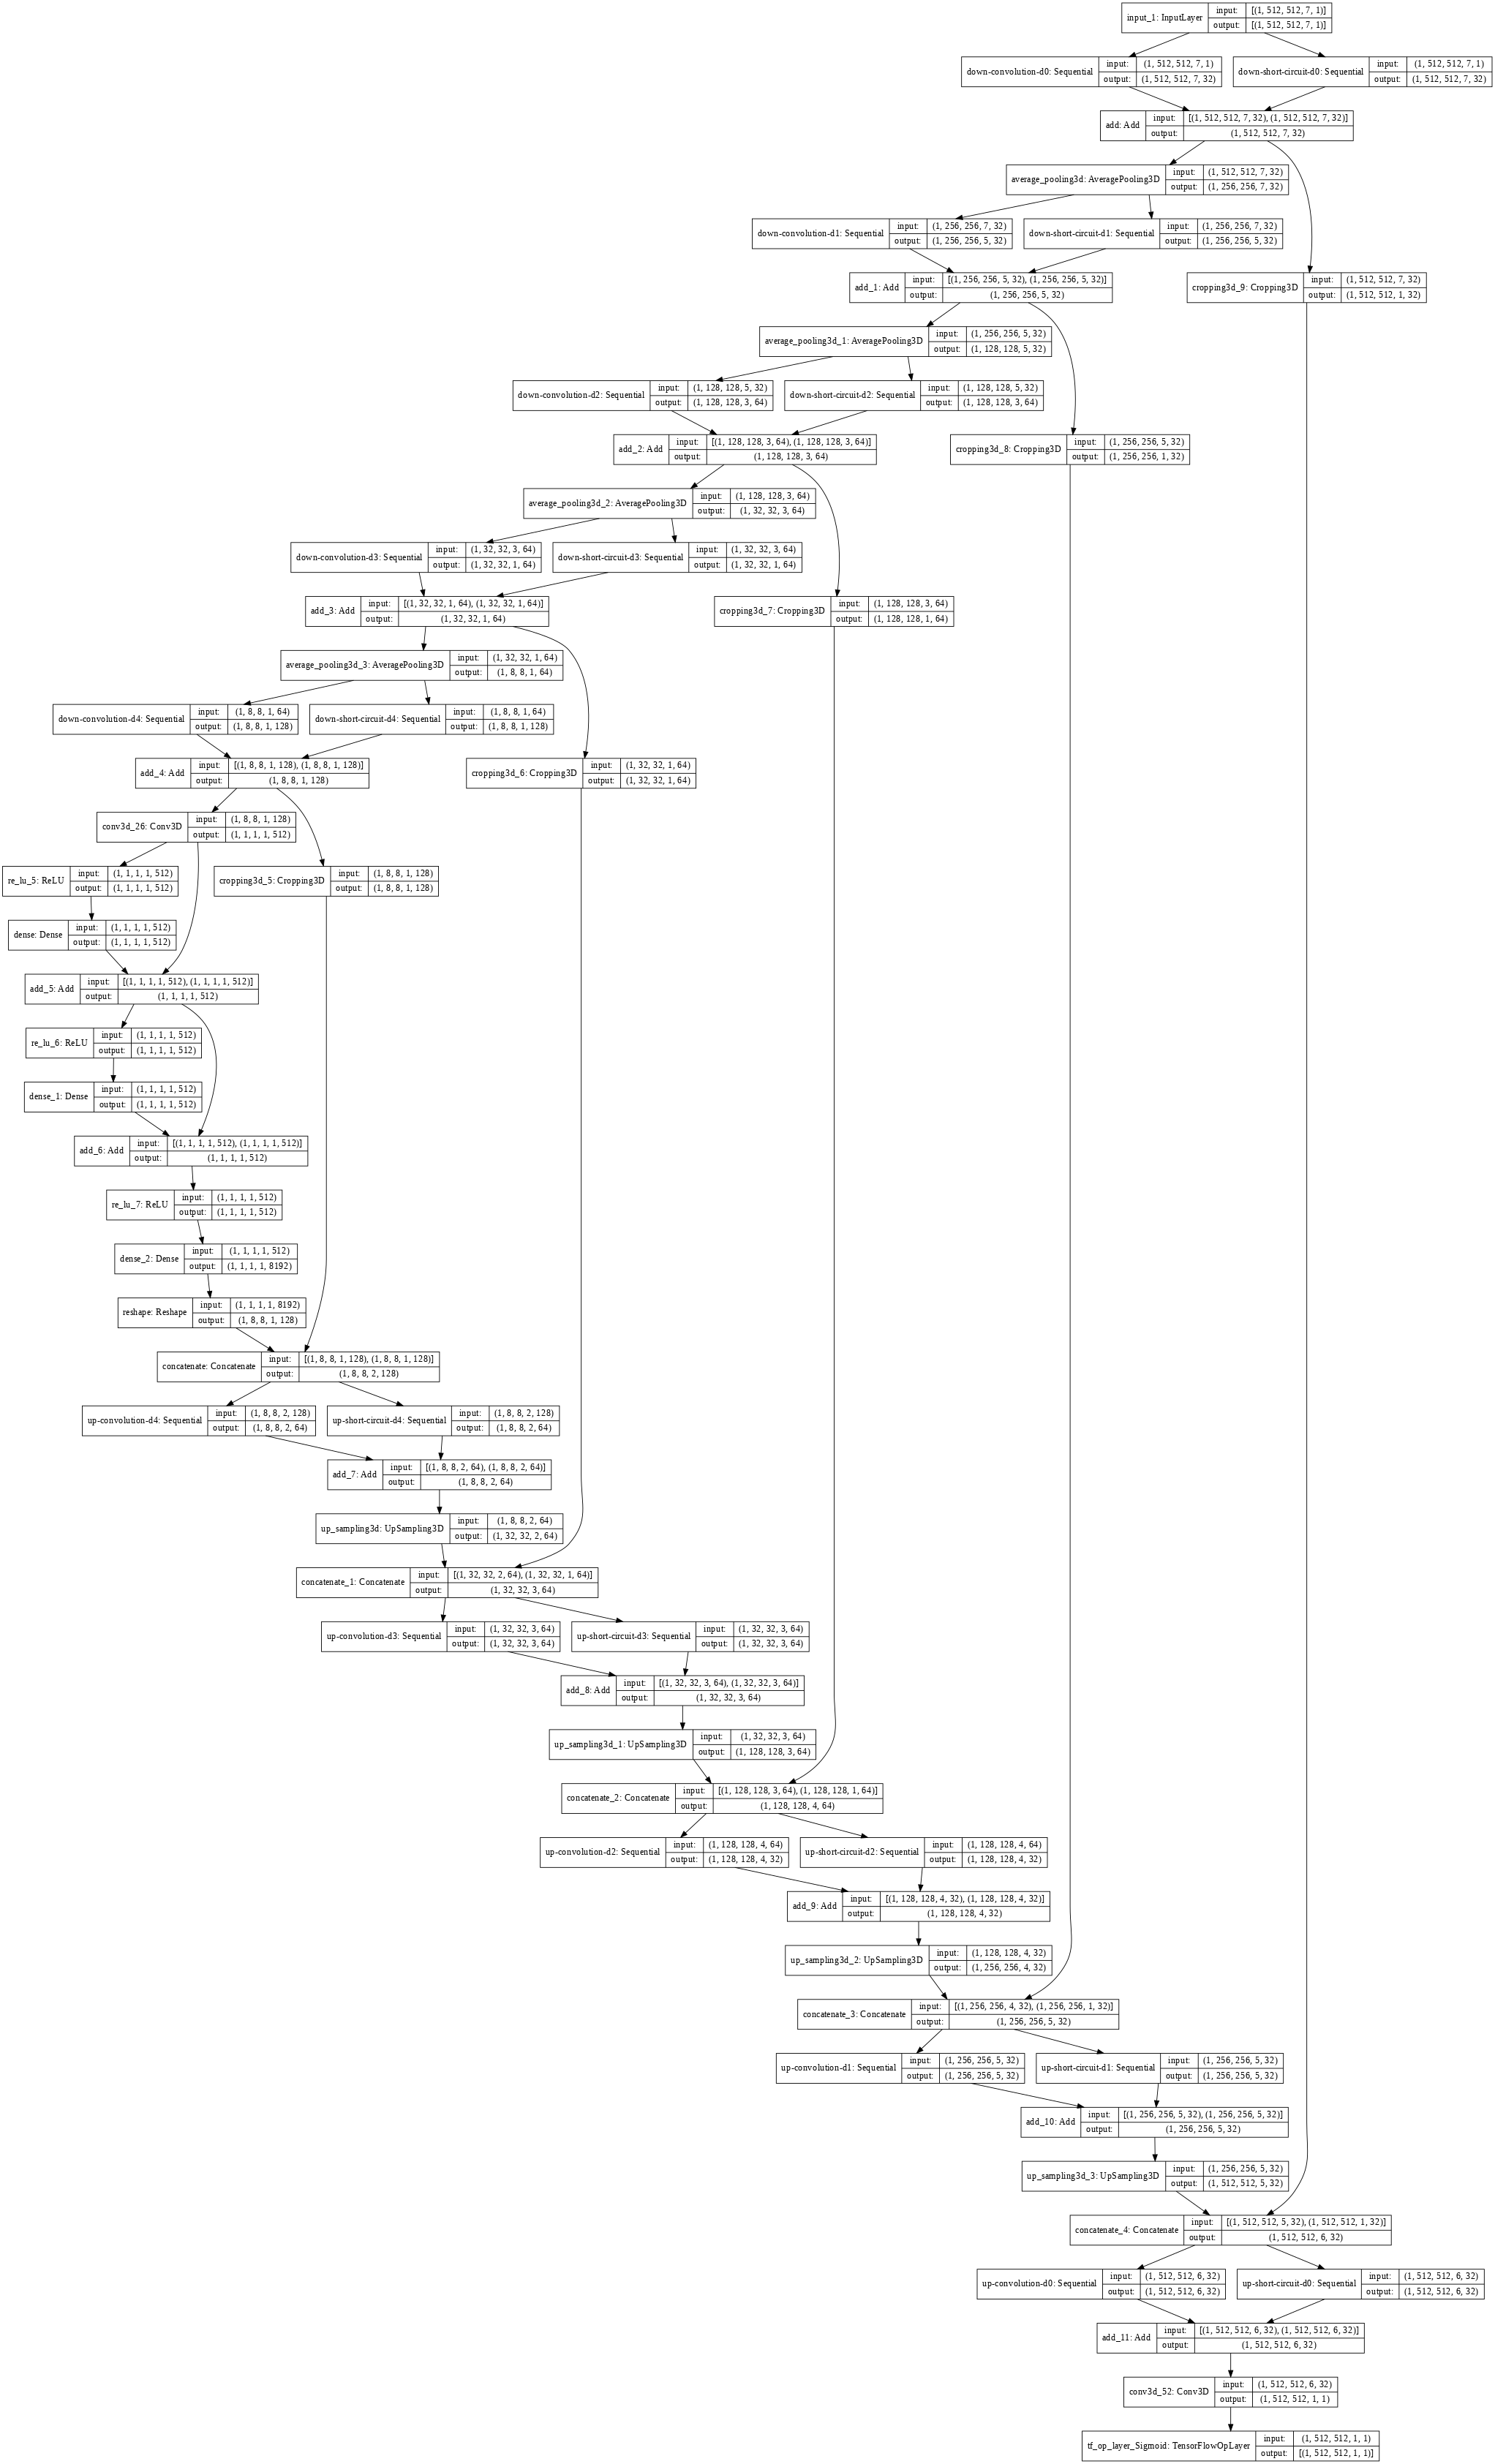

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [0]:
model.fit(
    test_dataset, 
    epochs=5, 
    steps_per_epoch=10, 
    validation_data=validation_dataset, 
    validation_steps=1)

Epoch 1/5
10/10 [==============================] - 22s 2s/step - loss: 0.0516 - val_loss: 0.0623
Epoch 2/5
10/10 [==============================] - 22s 2s/step - loss: 0.0391 - val_loss: 0.0625
Epoch 3/5
10/10 [==============================] - 19s 2s/step - loss: 0.0360 - val_loss: 0.0315
Epoch 4/5
10/10 [==============================] - 23s 2s/step - loss: 0.0485 - val_loss: 3.0136e-04
Epoch 5/5
 6/10 [=================>............] - ETA: 7s - loss: 0.0495